In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def plot_series(time, series, format = '-', start=0, end=None):
  plt.plot(time[start:end], series[start:end], format)
  plt.xlabel('Time')
  plt.ylabel('Value')
  plt.grid(True)

In [3]:
def trend(time, slope=0):
    return slope * time

In [4]:
def seasonal_pattern(season_time):
    """Just an arbitrary pattern, you can change it if you wish"""
    return np.where(season_time < 0.4,
                    np.cos(season_time * 2 * np.pi),
                    1 / np.exp(3 * season_time))

In [5]:
def seasonality(time, period, amplitude=1, phase=0):
    """Repeats the same pattern at each period"""
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)

In [6]:
def noise(time, noise_level=1, seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level

In [7]:
time = np.arange(4 * 365 + 1, dtype="float32")
baseline = 10
series = trend(time, 0.1)  
baseline = 10
amplitude = 40
slope = 0.05
noise_level = 5

series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)
series += noise(time, noise_level, seed=42)

In [8]:
split_time = 1000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

window_size = 20
batch_size = 32
shuffle_buffer_size = 1000

In [9]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
  dataset = tf.data.Dataset.from_tensor_slices(series)
  dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
  dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
  dataset = dataset.shuffle(shuffle_buffer).map(lambda window: (window[:-1], window[-1]))
  dataset = dataset.batch(batch_size).prefetch(1)
  return dataset

In [10]:
tf.random.set_seed(51)
np.random.seed(51)

train_set = windowed_dataset(x_train, window_size, batch_size = 128, shuffle_buffer=shuffle_buffer_size)

In [11]:
model = tf.keras.models.Sequential([
            tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis = -1), input_shape = [None]),
            tf.keras.layers.SimpleRNN(40, return_sequences=True), 
            tf.keras.layers.SimpleRNN(40),
            tf.keras.layers.Dense(1),
            tf.keras.layers.Lambda(lambda x: x * 100.0)
])

In [12]:
lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10 ** (epoch/20))


optimizer = tf.keras.optimizers.SGD(lr=1e-8, momentum=0.9)

model.compile(
              loss=tf.keras.losses.Huber(),
              optimizer = optimizer,
              metrics=['mae'])

history = model.fit(train_set, epochs = 1000, callbacks=[lr_schedule])

Epoch 1/1000
8/8 [==============================] - 2s 17ms/step - loss: 194.6263 - mae: 195.1263
Epoch 2/1000
8/8 [==============================] - 0s 12ms/step - loss: 195.2579 - mae: 195.7579
Epoch 3/1000
8/8 [==============================] - 0s 12ms/step - loss: 193.9793 - mae: 194.4793
Epoch 4/1000
8/8 [==============================] - 0s 12ms/step - loss: 192.3058 - mae: 192.8058
Epoch 5/1000
8/8 [==============================] - 0s 13ms/step - loss: 189.4673 - mae: 189.9673
Epoch 6/1000
8/8 [==============================] - 0s 13ms/step - loss: 187.5113 - mae: 188.0113
Epoch 7/1000
8/8 [==============================] - 0s 12ms/step - loss: 185.2976 - mae: 185.7976
Epoch 8/1000
8/8 [==============================] - 0s 11ms/step - loss: 183.4113 - mae: 183.9113
Epoch 9/1000
8/8 [==============================] - 0s 12ms/step - loss: 180.7795 - mae: 181.2795
Epoch 10/1000
8/8 [==============================] - 0s 12ms/step - loss: 176.5625 - mae: 177.0625
Epoch 11/1000
8/8 [

(1e-08, 0.0001, 0.0, 30.0)

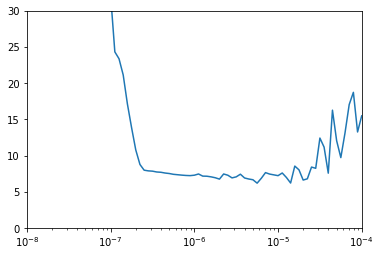

In [13]:
plt.semilogx(history.history['lr'], history.history['loss'])
plt.axis([1e-8, 1e-4, 0, 30])

In [14]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)

dataset = windowed_dataset(x_train, window_size, batch_size=128, shuffle_buffer=shuffle_buffer_size)

model = tf.keras.models.Sequential([
  tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),
                      input_shape=[None]),
  tf.keras.layers.SimpleRNN(40, return_sequences=True),
  tf.keras.layers.SimpleRNN(40),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 100.0)
])

optimizer = tf.keras.optimizers.SGD(lr=4e-5, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(dataset,epochs=400)

Epoch 1/400
8/8 [==============================] - 2s 13ms/step - loss: 110.1384 - mae: 110.6382
Epoch 2/400
8/8 [==============================] - 0s 12ms/step - loss: 20.5664 - mae: 21.0623
Epoch 3/400
8/8 [==============================] - 0s 12ms/step - loss: 15.1495 - mae: 15.6432
Epoch 4/400
8/8 [==============================] - 0s 13ms/step - loss: 12.2085 - mae: 12.7002
Epoch 5/400
8/8 [==============================] - 0s 12ms/step - loss: 9.5562 - mae: 10.0425
Epoch 6/400
8/8 [==============================] - 0s 11ms/step - loss: 15.0960 - mae: 15.5891
Epoch 7/400
8/8 [==============================] - 0s 12ms/step - loss: 10.8050 - mae: 11.2931
Epoch 8/400
8/8 [==============================] - 0s 11ms/step - loss: 7.8715 - mae: 8.3581
Epoch 9/400
8/8 [==============================] - 0s 11ms/step - loss: 8.0189 - mae: 8.5069
Epoch 10/400
8/8 [==============================] - 0s 12ms/step - loss: 7.5716 - mae: 8.0594
Epoch 11/400
8/8 [==============================] - 0s

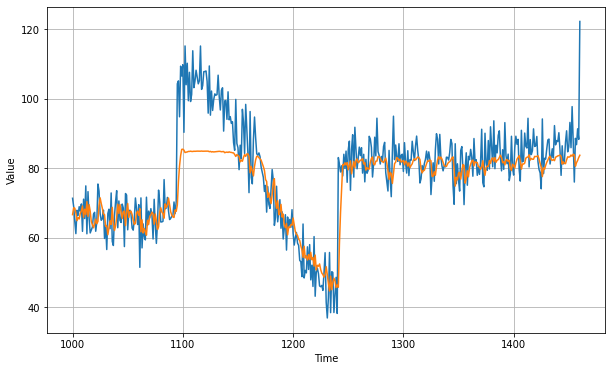

In [17]:
forecast=[]
for time in range(len(series) - window_size):
  forecast.append(model.predict(series[time:time + window_size][np.newaxis]))

forecast = forecast[split_time-window_size:]
results = np.array(forecast)[:, 0, 0]


plt.figure(figsize=(10, 6))

plot_series(time_valid, x_valid)
plot_series(time_valid, results)

In [20]:
tf.keras.metrics.mean_absolute_error(x_valid, results).numpy()

6.3149023

<Figure size 432x288 with 0 Axes>

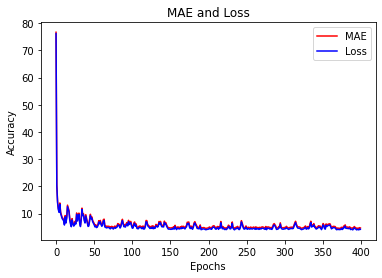

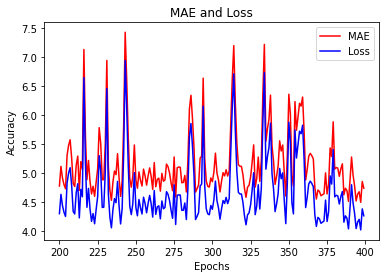

<Figure size 432x288 with 0 Axes>

In [21]:
import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
mae=history.history['mae']
loss=history.history['loss']

epochs=range(len(loss)) # Get number of epochs

#------------------------------------------------
# Plot MAE and Loss
#------------------------------------------------
plt.plot(epochs, mae, 'r')
plt.plot(epochs, loss, 'b')
plt.title('MAE and Loss')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["MAE", "Loss"])

plt.figure()

epochs_zoom = epochs[200:]
mae_zoom = mae[200:]
loss_zoom = loss[200:]

#------------------------------------------------
# Plot Zoomed MAE and Loss
#------------------------------------------------
plt.plot(epochs_zoom, mae_zoom, 'r')
plt.plot(epochs_zoom, loss_zoom, 'b')
plt.title('MAE and Loss')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["MAE", "Loss"])

plt.figure()